In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import os
import glob
import zipfile
from time import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 1. UNZIP AND LOAD FILE PATHS
zip_path = "/content/segmentation_data.zip"
extract_path = "/content/segmentation_data"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"Extracting {zip_path} to {extract_path}...")
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print(f"Directory {extract_path} already exists. Skipping extraction.")

images_path = "/content/segmentation_data/segmentation_data/Original Images"
masks_path  = "/content/segmentation_data/segmentation_data/Original Masks"

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Extracting /content/segmentation_data.zip to /content/segmentation_data...
Extraction complete.
Found 22 images and 22 masks


Train images: 17, Val images: 5
Visualizing samples from TRAIN dataset (after joint transforms)...


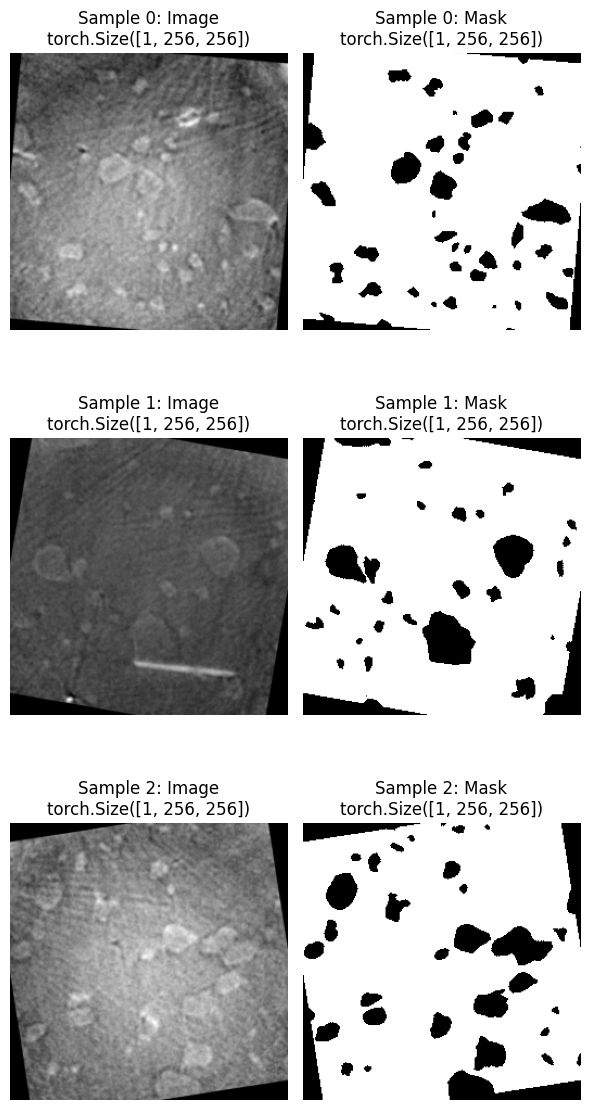


Foreground ratio (train set): 0.8574 (85.74%)
Sample 0 -> pores: 59288 / 65536 (90.47%)


In [10]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. JOINT TRANSFORM: same random ops for image & mask

class JointTransform:
    def __init__(self, size=(256, 256), do_augment=True):
        """
        size: (H, W) after resizing
        do_augment: if False, only resize + convert to tensors, no flips/rotations
        """
        self.size = size
        self.do_augment = do_augment

    def __call__(self, image, mask):
        #1) DATA AUGMENTATION
        if self.do_augment:
            # Random horizontal flip
            if random.random() < 0.5:
                image = TF.hflip(image)
                mask  = TF.hflip(mask)

            # Random small rotation
            angle = random.uniform(-10, 10)
            image = TF.rotate(
                image,
                angle,
                interpolation=transforms.InterpolationMode.BILINEAR
            )
            mask = TF.rotate(
                mask,
                angle,
                interpolation=transforms.InterpolationMode.NEAREST
            )

        #2) RESIZE
        image = TF.resize(
            image,
            self.size,
            interpolation=transforms.InterpolationMode.BILINEAR
        )
        mask = TF.resize(
            mask,
            self.size,
            interpolation=transforms.InterpolationMode.NEAREST
        )

        #3) IMAGE -> [0,1] FLOAT TENSOR (MIN-MAX NORM)
        np_img = np.array(image, dtype=np.float32)
        min_val, max_val = np.min(np_img), np.max(np_img)
        if max_val - min_val > 1e-6:
            np_img = (np_img - min_val) / (max_val - min_val)
        else:
            np_img = np.zeros_like(np_img, dtype=np.float32)
        img_tensor = torch.from_numpy(np_img).unsqueeze(0)  # [1,H,W]

        #4) MASK -> BINARY 0/1 FLOAT TENSOR
        mask_np = np.array(mask)
        # assume pores are white (>0), background black (0)
        mask_bin = (mask_np > 0).astype(np.float32)
        mask_tensor = torch.from_numpy(mask_bin).unsqueeze(0)  # [1,H,W]

        return img_tensor, mask_tensor



# 2. DATASET CLASS USING JOINT TRANSFORM

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, joint_transform=None):
        assert len(image_files) == len(mask_files), "Mismatch between images and masks"
        self.image_files = image_files
        self.mask_files = mask_files
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path  = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = Image.open(img_path)
        mask  = Image.open(mask_path)

        if self.joint_transform is not None:
            image, mask = self.joint_transform(image, mask)

        return image, mask


# 3. TRAIN / VAL DATASETS & LOADERS
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_files,
    mask_files,
    test_size=0.2,
    random_state=42
)

joint_train_transform = JointTransform(size=(256, 256), do_augment=True)
joint_val_transform   = JointTransform(size=(256, 256), do_augment=False)

train_dataset = SegmentationDataset(
    image_files=train_imgs,
    mask_files=train_masks,
    joint_transform=joint_train_transform
)

val_dataset = SegmentationDataset(
    image_files=val_imgs,
    mask_files=val_masks,
    joint_transform=joint_val_transform
)

batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}")


# 4.VISUALIZE SOME SAMPLES (AFTER TRANSFORMS)

def visualize_samples(dataset, n_samples=3):
    plt.figure(figsize=(6, n_samples * 4))
    for i in range(n_samples):
        img_tensor, mask_tensor = dataset[i]
        img = img_tensor.squeeze().numpy()
        msk = mask_tensor.squeeze().numpy()

        # Image
        plt.subplot(n_samples, 2, 2*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Sample {i}: Image\n{img_tensor.shape}")
        plt.axis('off')

        # Mask
        plt.subplot(n_samples, 2, 2*i + 2)
        plt.imshow(msk, cmap='gray')
        plt.title(f"Sample {i}: Mask\n{mask_tensor.shape}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing samples from TRAIN dataset (after joint transforms)...")
visualize_samples(train_dataset, n_samples=3)


# 5. FOREGROUND PIXEL RATIO (IMBALANCE CHECK)
foreground_pixels = 0
total_pixels = 0

for i in range(len(train_dataset)):
    _, mask_tensor = train_dataset[i]   # [1,H,W]
    m = mask_tensor.float()
    foreground_pixels += m.sum().item()
    total_pixels += m.numel()

fg_ratio = foreground_pixels / total_pixels
print(f"\nForeground ratio (train set): {fg_ratio:.4f} ({fg_ratio*100:.2f}%)")

# Optionally check a single sample too
img0, mask0 = train_dataset[0]
pore_pixels = mask0.sum().item()
total0 = mask0.numel()
print(f"Sample 0 -> pores: {int(pore_pixels)} / {int(total0)} "
      f"({100 * pore_pixels / total0:.2f}%)")


In [12]:

# 3. DATASET SPLITTING AND DATALOADERS (with JointTransform)

torch.manual_seed(42)  # for reproducible splits

total_size = len(image_files)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size

print(f"Total samples:     {total_size}")
print(f"Training samples:  {train_size}")
print(f"Validation samples:{val_size}")
print(f"Test samples:      {test_size}")

# Create a random permutation of indices
indices = torch.randperm(total_size)

train_indices = indices[:train_size]
val_indices   = indices[train_size:train_size + val_size]
test_indices  = indices[train_size + val_size:]

# Helper to index lists with tensor indices
def subset_files(files, idxs):
    return [files[i] for i in idxs]

train_image_files = subset_files(image_files, train_indices)
train_mask_files  = subset_files(mask_files,  train_indices)

val_image_files   = subset_files(image_files, val_indices)
val_mask_files    = subset_files(mask_files,  val_indices)

test_image_files  = subset_files(image_files, test_indices)
test_mask_files   = subset_files(mask_files,  test_indices)

print("\nCreating datasets with joint transforms...")

# Joint transforms: augment only on train
joint_train_transform = JointTransform(size=(256, 256), do_augment=True)
joint_val_transform   = JointTransform(size=(256, 256), do_augment=False)
joint_test_transform  = JointTransform(size=(256, 256), do_augment=False)

train_dataset = SegmentationDataset(
    image_files=train_image_files,
    mask_files=train_mask_files,
    joint_transform=joint_train_transform
)

val_dataset = SegmentationDataset(
    image_files=val_image_files,
    mask_files=val_mask_files,
    joint_transform=joint_val_transform
)

test_dataset = SegmentationDataset(
    image_files=test_image_files,
    mask_files=test_mask_files,
    joint_transform=joint_test_transform
)

# Dataloaders
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

print("\nDataLoaders created.")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


Total samples:     22
Training samples:  17
Validation samples:2
Test samples:      3

Creating datasets with joint transforms...

DataLoaders created.
Train batches: 3, Val batches: 1, Test batches: 1


In [13]:
# 4. SANITY CHECK
try:
    images, masks = next(iter(train_loader))
    print(f"Images batch shape: {images.shape}")  # Should be [B, 1, 256, 256]
    print(f"Masks batch shape:  {masks.shape}")   # Should be [B, 1, 256, 256]
    print(f"Mask tensor data type: {masks.dtype}")
    print(f"Mask min value: {masks.min()}")
    print(f"Mask max value: {masks.max()}")
    print(f"Unique mask values in batch: {torch.unique(masks)}")
except (StopIteration, NameError):
    print("ERROR: Could not fetch a batch from train_loader. Check data paths/splitting.")

Images batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape:  torch.Size([8, 1, 256, 256])
Mask tensor data type: torch.float32
Mask min value: 0.0
Mask max value: 1.0
Unique mask values in batch: tensor([0., 1.])


In [14]:
import torch


def dice_overlap(y_real, y_pred):
    intersection = torch.sum(torch.mul(y_real, y_pred))
    denominator = torch.sum(y_real) + torch.sum(y_pred)

    return (2 * intersection) / denominator


def intersection_over_union(y_real, y_pred):
    intersection = torch.sum(torch.mul(y_real, y_pred))
    union = torch.sum(y_real) + torch.sum(y_pred) - intersection

    return intersection/union


def accuracy(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    correct_predictions = torch.sum(y_real == y_pred)
    total_pixels = y_real.size(0)

    return correct_predictions.float() / total_pixels


def sensitivity(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    tp = torch.sum((y_real == 1) & (y_pred == 1))
    fn = torch.sum((y_real == 1) & (y_pred == 0))

    return tp / (tp + fn)


def specificity(y_real, y_pred):
    tn = torch.sum((y_real == 0) & (y_pred == 0))
    fp = torch.sum((y_real == 0) & (y_pred == 1))

    return tn / (tn + fp)

In [15]:
# 5. LOSS FUNCTIONS

class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        return loss

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        p = torch.sigmoid(y_pred)
        if p.dim() == 3:
            p = p.unsqueeze(1)
            y_true = y_true.unsqueeze(1)
        elif y_true.dim() == 3:
            y_true = y_true.unsqueeze(1)
        N = p.shape[0]
        p_f = p.contiguous().view(N, -1)
        y_f = y_true.contiguous().view(N, -1)
        smooth = 1.0
        intersection = (p_f * y_f).sum(dim=1)
        denom = p_f.sum(dim=1) + y_f.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (denom + smooth)
        return (1.0 - dice).mean()

class FocalLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        bce = nn.functional.binary_cross_entropy_with_logits(y_pred, y_true, reduction="none")
        p = torch.sigmoid(y_pred)
        pt = p * y_true + (1 - p) * (1 - y_true)
        gamma = 2.0
        focal = torch.pow((1 - pt).clamp(min=1e-6), gamma)
        loss = focal * bce
        return loss.mean()

class BCELoss_TotalVariation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        x = torch.sigmoid(y_pred)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        dh = x[:, :, 1:, :] - x[:, :, :-1, :]
        dw = x[:, :, :, 1:] - x[:, :, :, :-1]
        regularization = dh.abs().mean() + dw.abs().mean()
        return loss + 0.1*regularization

class DiceBCELoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_true):
        dice_loss = self.dice(y_pred, y_true)
        bce_loss  = self.bce(y_pred, y_true.float())
        return self.alpha * dice_loss + (1 - self.alpha) * bce_loss


In [16]:
# 6. UNET MODEL

class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    # Default in_channels=1 is correct for our 1-channel grayscale image
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)
        out = self.output_conv(d1)
        return out

In [17]:
#we add some early stopping to enhance performance of the model
#when using data aug.

class EarlyStopping:
    def __init__(self, patience, min_delta):
        """
        patience: How many epochs to wait after last improvement
        min_delta: Minimum change in validation loss to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss

        elif val_loss > self.best_loss - self.min_delta:
            # No significant improvement
            self.counter += 1
            print(f"  -> EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            # Improvement observed: reset counter
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=7, min_delta=0.0001)


In [18]:
import random
# --- Set a seed for reproducibility ---
SEED = 42

def set_seed(seed):
    """Sets the seed for all random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU

    # These two settings are for full reproducibility on CUDA (if available)
    # They can slow down training, but are necessary for a fixed outcome
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(SEED)

print(f"Reproducibility seed set to {SEED}")

# 7. TRAINING
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# We use the default in_channels=1
model = UNet(in_channels=1, out_channels=1).to(device)
learning_rate = 1e-3
#learning_rate = 1e-4
opt = optim.Adam(model.parameters(), learning_rate)

# Select your loss function
#loss_fn = DiceLoss()
#loss_fn = BCELoss()
#loss_fn = FocalLoss()
# loss_fn = BCELoss_TotalVariation()
loss_fn = DiceBCELoss(alpha=0.5)
print(f"Using loss function: {loss_fn.__class__.__name__}")
epochs = 60

#use more epochs for early stopping:
#epochs = 100

# Lists to store losses
train_losses = []
val_losses = []

print("\nStarting training...")

for epoch in range(epochs):
    tic = time()

    # -----------------------------
    # TRAINING
    # -----------------------------
    model.train()
    avg_loss = 0
    avg_acc = 0

    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        opt.zero_grad()

        y_pred_logits = model(X_batch)
        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        opt.step()

        avg_loss += loss.item() / len(train_loader)

        # ---- Training accuracy only ----
        y_pred = torch.sigmoid(y_pred_logits)
        y_pred_bin = (y_pred > 0.5).float()
        avg_acc += accuracy(y_true, y_pred_bin).item() / len(train_loader)

    # -----------------------------
    # VALIDATION
    # -----------------------------
    model.eval()
    avg_val_loss = 0
    avg_dice = 0
    avg_iou = 0
    avg_val_acc = 0
    avg_sens = 0
    avg_spec = 0

    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)

            y_pred_logits = model(X_batch)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)

            # ---- Convert to binary ----
            y_pred = torch.sigmoid(y_pred_logits)
            y_pred_bin = (y_pred > 0.5).float()

            # ---- Validation metrics ----
            avg_dice += dice_overlap(y_true, y_pred_bin).item() / len(val_loader)
            avg_iou += intersection_over_union(y_true, y_pred_bin).item() / len(val_loader)
            avg_val_acc += accuracy(y_true, y_pred_bin).item() / len(val_loader)
            avg_sens += sensitivity(y_true, y_pred_bin).item() / len(val_loader)
            avg_spec += specificity(y_true, y_pred_bin).item() / len(val_loader)

    toc = time()

    # -----------------------------
    # PRINTING
    # -----------------------------
    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Train Acc : {avg_acc:.4f}')
    print(f'  - Val Loss  : {avg_val_loss:.4f}')
    print(f'  - Val Dice  : {avg_dice:.4f}')
    print(f'  - Val IoU   : {avg_iou:.4f}')
    print(f'  - Val Acc   : {avg_val_acc:.4f}')
    print(f'  - Val Sens  : {avg_sens:.4f}')
    print(f'  - Val Spec  : {avg_spec:.4f}\n')

    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    #do the early stopping here!!!
    #early_stopping(avg_val_loss)
    #if early_stopping.early_stop:
     #print("Early stopping triggered!")
     #break


Reproducibility seed set to 42
Using device: cuda
Using loss function: DiceBCELoss

Starting training...
* Epoch 01/60 (Time: 3.12s)
  - Train Loss: 0.4110
  - Train Acc : 0.7906
  - Val Loss  : 0.4807
  - Val Dice  : 0.9401
  - Val IoU   : 0.8870
  - Val Acc   : 0.8870
  - Val Sens  : 1.0000
  - Val Spec  : 0.0000

* Epoch 02/60 (Time: 1.62s)
  - Train Loss: 0.3638
  - Train Acc : 0.8411
  - Val Loss  : 0.4456
  - Val Dice  : 0.9401
  - Val IoU   : 0.8870
  - Val Acc   : 0.8870
  - Val Sens  : 1.0000
  - Val Spec  : 0.0000

* Epoch 03/60 (Time: 1.48s)
  - Train Loss: 0.2882
  - Train Acc : 0.8847
  - Val Loss  : 0.3942
  - Val Dice  : 0.9401
  - Val IoU   : 0.8870
  - Val Acc   : 0.8870
  - Val Sens  : 1.0000
  - Val Spec  : 0.0000

* Epoch 04/60 (Time: 1.46s)
  - Train Loss: 0.2727
  - Train Acc : 0.8837
  - Val Loss  : 0.4386
  - Val Dice  : 0.8556
  - Val IoU   : 0.7477
  - Val Acc   : 0.7504
  - Val Sens  : 0.8340
  - Val Spec  : 0.0940

* Epoch 05/60 (Time: 1.48s)
  - Train Loss:

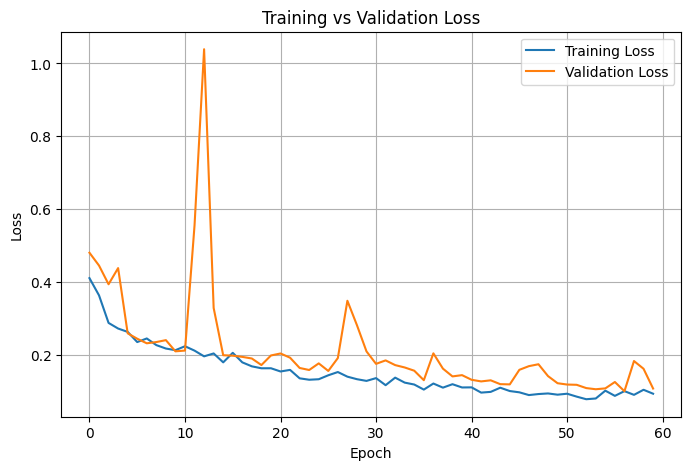

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# # --- 8. Save the model ---
# os.makedirs("results", exist_ok=True)
# torch.save(model.state_dict(), "results/EncDec_model.pth")
# print("\nTraining has finished! Model saved to results/EncDec_model.pth")


Starting evaluation on the test set...
Test Set Results (Averaged over 1 batches)
Pixel Accuracy (Rand): 94.56%
Dice Coefficient:      0.9699
Jaccard Index (IoU):   0.9416
Precision:             0.9598
Recall (Sensitivity):  0.9802

 Test Set Pixel Distribution (Ground Truth)
Total Pixels (all test masks): 196608
Total Pore (Foreground) Pixels: 175910 (89.47%)
Total Background Pixels:        20698 (10.53%)

Visualizing some test predictions...


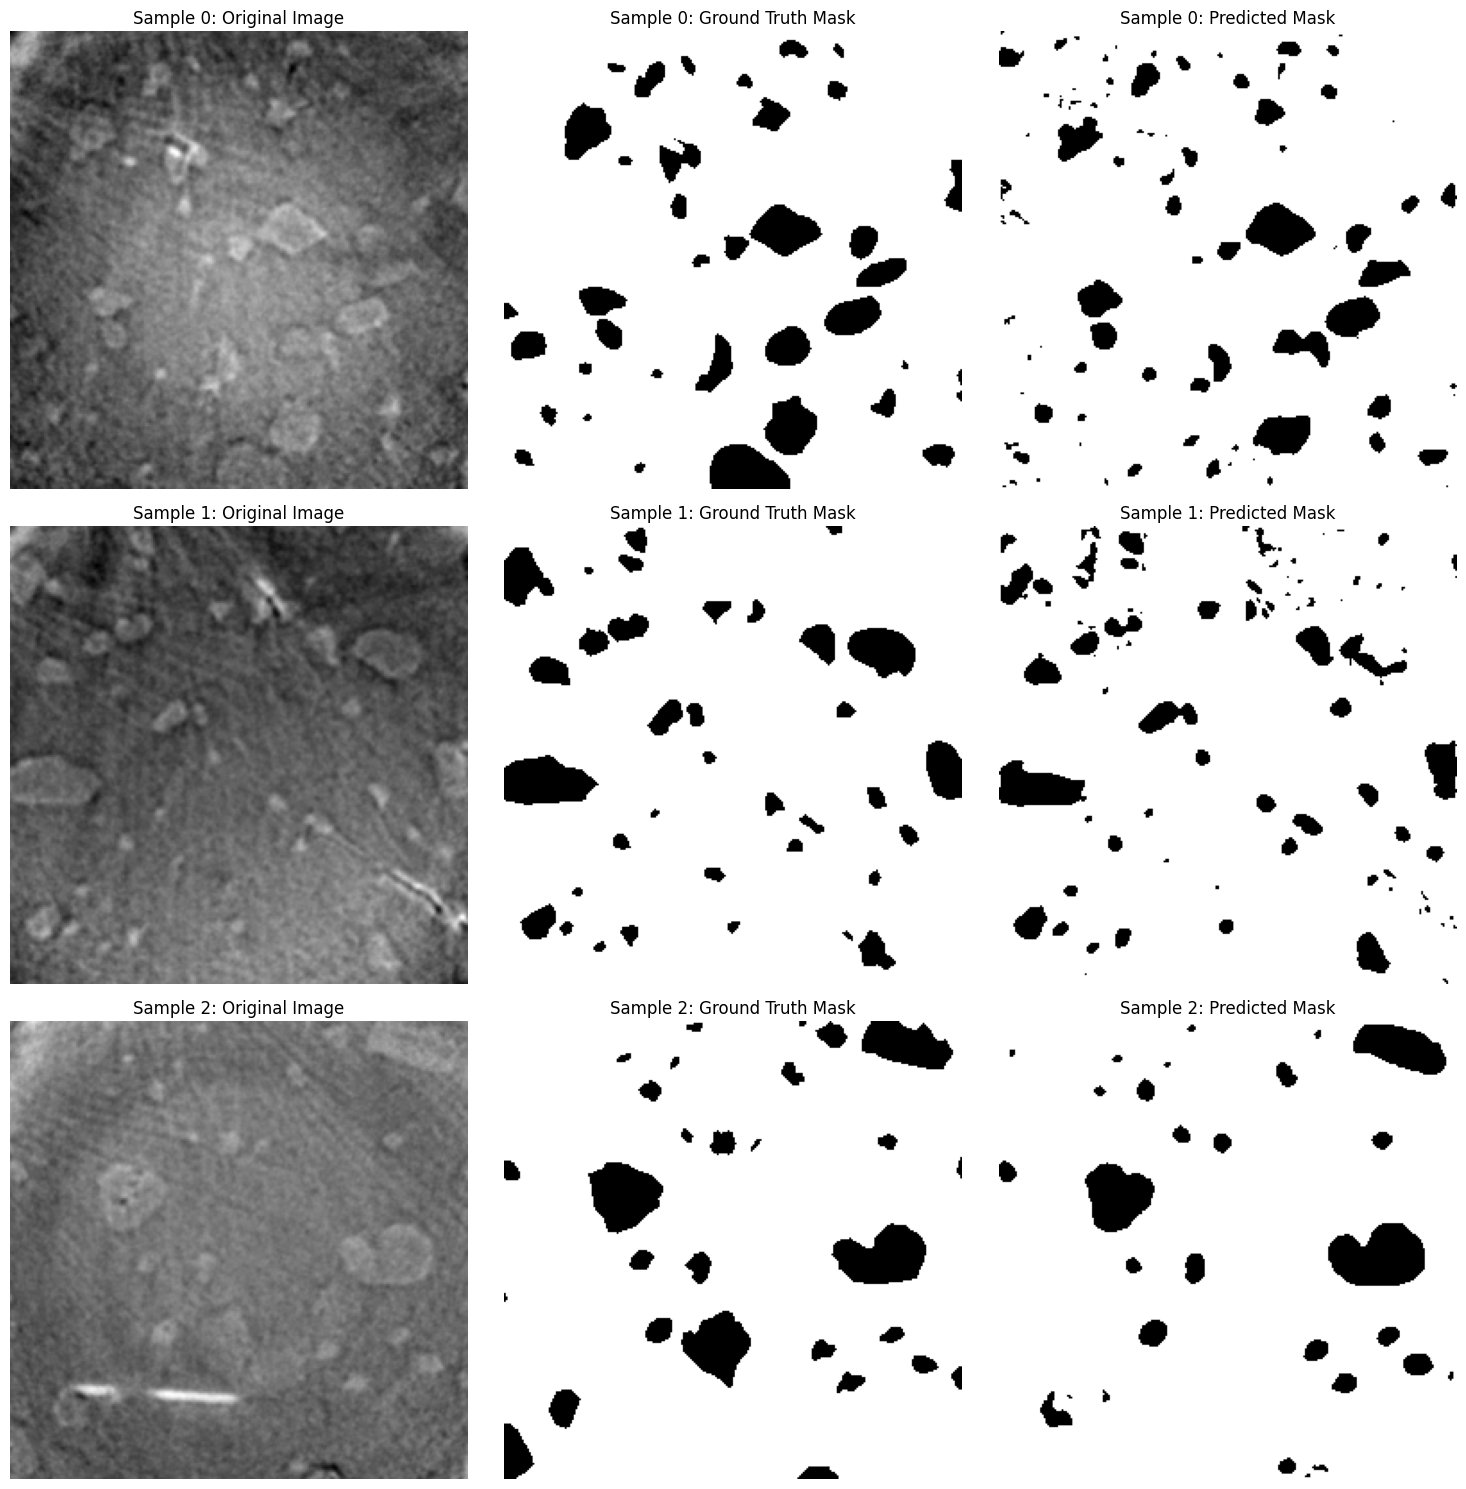

In [20]:
# 1. SETUP FOR EVALUATION
model.eval()

# 2. METRIC FUNCTION
def calculate_all_metrics_batch(preds, y_true, smooth=1e-6):
    """
    Calculates all 5 metrics for a batch.
    Metrics are computed pixel-wise for the entire batch.
    """
    # Flatten tensors
    preds_f = preds.contiguous().view(-1).float()
    y_f = y_true.contiguous().view(-1).float()

    # Core Components
    tp = (preds_f * y_f).sum()
    fp = (preds_f * (1 - y_f)).sum()
    fn = ((1 - preds_f) * y_f).sum()
    tn = ((1 - preds_f) * (1 - y_f)).sum()
    total_pixels = y_f.numel()

    # Calculate Metrics
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    accuracy = (tp + tn) / total_pixels
    dice = (2.0 * tp + smooth) / (tp + fp + tp + fn + smooth)
    jaccard = (tp + smooth) / (tp + fp + fn + smooth)

    return precision.item(), recall.item(), accuracy.item(), dice.item(), jaccard.item()


# 3. TEST SET EVALUATION LOOP
print("\nStarting evaluation on the test set...")

# Initialize accumulators for all metrics
total_precision = 0
total_recall = 0
total_accuracy = 0
total_dice = 0
total_jaccard = 0
total_pore_pixels = 0
total_bg_pixels = 0

# Disable gradient calculations
with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # 1. Forward pass (get logits)
        y_pred_logits = model(X_batch)

        # 2. Convert logits to binary predictions
        y_pred_probs = torch.sigmoid(y_pred_logits)
        y_pred_binary = (y_pred_probs > 0.5).float() # Threshold at 0.5

        # 3. Calculate all metrics for this batch and add to totals
        p, r, acc, d, j = calculate_all_metrics_batch(y_pred_binary, y_true)

        total_precision += p
        total_recall    += r
        total_accuracy  += acc
        total_dice      += d
        total_jaccard   += j


        # 4. Calculate pixel counts from the ground truth masks
        batch_pores = y_true.sum().item()
        batch_total = y_true.numel()
        batch_bg = batch_total - batch_pores

        total_pore_pixels += batch_pores
        total_bg_pixels += batch_bg

# CALCULATE AND PRINT FINAL METRICS
num_batches = len(test_loader)
avg_precision = total_precision / num_batches
avg_recall    = total_recall / num_batches
avg_accuracy  = total_accuracy / num_batches
avg_dice      = total_dice / num_batches
avg_jaccard   = total_jaccard / num_batches

print(f"Test Set Results (Averaged over {num_batches} batches)")
print(f"Pixel Accuracy (Rand): {avg_accuracy * 100:.2f}%")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")
print(f"Precision:             {avg_precision:.4f}")
print(f"Recall (Sensitivity):  {avg_recall:.4f}")

print("\n Test Set Pixel Distribution (Ground Truth)")
total_pixels_all = total_pore_pixels + total_bg_pixels
pore_percentage = (total_pore_pixels / total_pixels_all) * 100
bg_percentage = (total_bg_pixels / total_pixels_all) * 100

print(f"Total Pixels (all test masks): {int(total_pixels_all)}")
print(f"Total Pore (Foreground) Pixels: {int(total_pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Total Background Pixels:        {int(total_bg_pixels)} ({bg_percentage:.2f}%)")


# VISUALIZE A FEW PREDICTIONS
print("\nVisualizing some test predictions...")

# Get one batch from the test loader
X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

model.eval()
with torch.no_grad():
    y_pred_logits_viz = model(X_test_viz)
    y_pred_probs_viz = torch.sigmoid(y_pred_logits_viz)
    y_pred_binary_viz = (y_pred_probs_viz > 0.5).float()

# Move data to CPU for plotting with numpy/matplotlib
X_test_cpu = X_test_viz.cpu()
y_test_cpu = y_test_viz.cpu()
y_pred_cpu = y_pred_binary_viz.cpu()

# Plot the first N samples (e.g., 3)
n_samples_to_plot = min(3, len(X_test_cpu)) # Ensure we don't exceed batch size

plt.figure(figsize=(15, n_samples_to_plot * 5))
for i in range(n_samples_to_plot):

    # a) Original Image (1-channel)
    plt.subplot(n_samples_to_plot, 3, i*3 + 1)
    plt.imshow(X_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Original Image")
    plt.axis('off')

    # b) Ground Truth Mask
    plt.subplot(n_samples_to_plot, 3, i*3 + 2)
    plt.imshow(y_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Ground Truth Mask")
    plt.axis('off')

    # c) Predicted Mask
    plt.subplot(n_samples_to_plot, 3, i*3 + 3)
    plt.imshow(y_pred_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
#testing, Theo version

model.eval()

total_dice = 0
total_iou = 0
total_acc = 0
total_sens = 0
total_spec = 0

with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_pred_logits = model(X_batch)
        y_pred = torch.sigmoid(y_pred_logits)
        y_pred_bin = (y_pred > 0.5).float()

        # Compute metrics for this batch
        dice_score = dice_overlap(y_true, y_pred_bin).item()
        iou_score = intersection_over_union(y_true, y_pred_bin).item()
        acc_score = accuracy(y_true, y_pred_bin).item()
        sens_score = sensitivity(y_true, y_pred_bin).item()
        spec_score = specificity(y_true, y_pred_bin).item()

        # Accumulate
        total_dice += dice_score
        total_iou += iou_score
        total_acc += acc_score
        total_sens += sens_score
        total_spec += spec_score

# Average over number of test batches
num_batches = len(test_loader)

avg_dice = total_dice / num_batches
avg_iou = total_iou / num_batches
avg_acc = total_acc / num_batches
avg_sens = total_sens / num_batches
avg_spec = total_spec / num_batches

# Print results
print("\n===== TEST SET RESULTS =====")
print(f"Dice Coefficient:     {avg_dice:.4f}")
print(f"IoU (Jaccard):        {avg_iou:.4f}")
print(f"Accuracy:             {avg_acc:.4f}")
print(f"Sensitivity (Recall): {avg_sens:.4f}")
print(f"Specificity:          {avg_spec:.4f}")
print("=============================\n")



===== TEST SET RESULTS =====
Dice Coefficient:     0.9699
IoU (Jaccard):        0.9416
Accuracy:             0.9456
Sensitivity (Recall): 0.9802
Specificity:          0.6511

